# Code for generating SFigure 8 from derivative data (not provided in this repo)

#### Raw code for generating derivative data is in 
`analysis5_model_traindat1dat2_richVsLazyLearning.py --optim 'sgd' --learning_rate 0.01`
#### Batch script is in:
`analysis5_batch.sh`, line 44

#### Example command (within batch)

`python analysis5_model_traindat1dat2_richVsLazyLearning.py --weight_init 1.0 --bias_init 0 --nhidden 500 --nlayers 5 --normalize --cuda --outfilename analysis5_run${SLURM_ARRAY_TASK_ID} --optim 'sgd' --learning_rate 0.01`

Note that weight_init needs to be varied according to parameters reported in Methods (0.2 to 2.0, in 0.2 increments)

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

## N.B.: In this demo notebook, trained ANN parameters are not provided due to large file size. However, ANNs can be trained using the provided scripts.

In [2]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import dimensionality

#### Set up basic parameters

In [3]:
figuredir = '../figures/SFig8/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']
sensorynets = ['vis1','vis2','aud']
motornets = ['smn']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
boxpalette = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2]]
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Model params

In [4]:
nhidden = 500
nlayers = 5
outfilename = 'analysis5_run'
bias_init = '_biasinit0.0'
relu = ''
optim = '_optimsgd'
normalize = '_normalize'
lr = '_lr0.01'
weight_init_range = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4] #, 1.4, 1.6, 1.8, 2.0]

untied = ''
nsimulations = 20

# Load dimensionality of different initial weight conditions

In [121]:
df_dim_group = pd.DataFrame()
for weightinit in weight_init_range:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + lr + relu + normalize
        try:
            df_dim = pd.read_csv(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv')

            tmpdf = df_dim.groupby('Layer',as_index=False).mean()
            tmpdf.insert(loc=0,column='WeightInit', value=np.repeat(weightinit,nlayers+2))
            tmpdf.insert(loc=0,column='Simulation', value=np.repeat(sim,nlayers+2))

            df_dim_group = df_dim_group.append(tmpdf)
            # Insert new columns
        except:
            print("Error, can't find:", outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv', '---- run,', sim, ' | weight', weightinit)

        
del df_dim_group['Subject'], df_dim_group['Unnamed: 0']
        
    


# Plot dimensionality for weight initializations

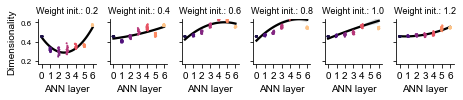

In [122]:
weights_to_plot = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
plt.figure(figsize=(6.5,1.5))

i = 1
for weight in weights_to_plot:
    plt.subplot(1,6,i)
    tmpdf = df_dim_group.loc[df_dim_group.WeightInit==weight]
    layers = tmpdf.Layer.values - 1
    del tmpdf['Layer']
    tmpdf.insert(loc=0,column='Layer', value=layers)
    sns.stripplot(x="Layer",y="Dimensionality",data=tmpdf,palette='magma',size=2)
    sns.regplot(x="Layer",y="Dimensionality",data=tmpdf,color='k',order=2,scatter=False)
    plt.xlabel('ANN layer',fontsize=10)
    plt.title('Weight init.: ' + str(weight),fontsize=9)
    if i == 1:
        plt.yticks([0.2,.4,.6], [.2, .4, .6],fontsize=8)
        plt.ylabel('Dimensionality',fontsize=10)      
    else:
        plt.yticks([.2,.4,.6],[])
        plt.ylabel(None)

    plt.ylim([0.17,0.63])
    i += 1
sns.despine()
plt.tight_layout()
# plt.savefig(figuredir + 'DimensionalityXLayerWeightInitialization.pdf')

              


#### For each 2nd order fit, evaluate the quadratic coeffcient magnitude and the r-squared

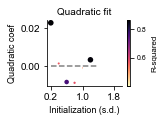

In [123]:
import statsmodels.api as sm

df_fit  = {}
df_fit['R-squared'] = []
df_fit['Quadratic coef'] = []
df_fit['Weight init.'] = []
for weight in weight_init_range:

    tmpdf = df_dim_group.loc[df_dim_group.WeightInit==weight]

    # 
    x = tmpdf.Layer.values
    x.shape = (len(x),1)
    y = tmpdf.Dimensionality.values
    ## 2nd order model
    polynomial_features = PolynomialFeatures(degree=2)
    xp2 = polynomial_features.fit_transform(x)

    #fit regression model
    model2 = sm.OLS(y, xp2).fit()

    df_fit['R-squared'].append(model2.rsquared)
    df_fit['Quadratic coef'].append(model2.params[2])
    df_fit['Weight init.'].append(weight)
df_fit = pd.DataFrame(df_fit)

color3 = sns.color_palette('Set2')[2]
plt.figure(figsize=(2.4,1.8))
ax = sns.scatterplot(x="Weight init.", y="Quadratic coef", data=df_fit, hue="R-squared", size="R-squared",sizes=(0,75),alpha=1, label='2nd coef.',palette='magma_r',legend=False,linewidth=3,color=color3)
ax.set_xlabel('Initialization (s.d.)',fontsize=9)
ax.set_ylabel('Quadratic coef', color='k',fontsize=9)
plt.plot(weight_init_range,np.repeat(0,len(weight_init_range)),'--',color='grey')
ax.tick_params(axis='y', labelcolor='k')
ax.set_xticks(np.arange(0.2,2.0,0.8))
ax.set_xlim([0.1,2.0])
ax.set_title('Quadratic fit',fontsize=10)
#
norm = plt.Normalize(df_fit['R-squared'].min(), df_fit['R-squared'].max())
smap = plt.cm.ScalarMappable(cmap="magma_r", norm=norm)
smap.set_array([])
cax = ax.figure.colorbar(smap)
cax.ax.tick_params(labelsize=7)
cax.ax.set_ylabel('R-squared', fontsize=8);
plt.tight_layout()
sns.despine()


____

# Compare model produced RSMs with hierarchical empirical RSMs

In [124]:
rsms_model = []
for weight in weight_init_range:
    rsms = []
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weight) + bias_init + optim + lr + relu + normalize
        try:
            df_dim = pd.read_csv(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv')

            h5f = h5py.File(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5','r')
            tmp = h5f['data'][:].copy()
            h5f.close()
            rsms.append(np.mean(tmp,axis=0))
        except:
            print("Error, can't find:", outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv', '---- run,', sim, ' | weight', weight)    
    rsms = np.asarray(rsms)
    rsms_model.append(rsms)

rsms_model = np.asarray(rsms_model)


# Load in empirical RSMs and compute each region's representational similarity with each layer's representational similarity

In [125]:
rsm_matrix = 'cosine'
# Load emiprical RSMs
h5f = h5py.File(basedir + 'derivatives/results/analysis1/analysis1_regional_rdms_' + rsm_matrix + '_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()
h5f.close()
rsms_empirical = np.mean(np.arctanh(rsms_subj),axis=1)

# Load RSM gradients
distance = 'cosine'
rsm_matrix = 'cosine'
rsm_gradients = np.loadtxt(basedir + 'derivatives/results/analysis1/analysis1_' + distance + '_3components_' + rsm_matrix + 'RSMs_representational_gradients.csv')
df_dim = pd.read_csv(basedir + 'derivatives/results/analysis1/analysis1_parcel_' + rsm_matrix + '_dimensionality.csv')
# Load empirical dimensionality
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)

nParcels = rsms_empirical.shape[0]
numlayers = rsms_model.shape[2]
ntasks = 45
triu_ind = np.triu_indices(ntasks,k=0)

ann_brain_rsm_match = np.zeros((nParcels,numlayers,nsimulations,len(weight_init_range)))
for sim in range(rsms_model.shape[1]):
    for weight_ind in range(len(weight_init_range)):
        for layer in range(numlayers):
            for parcel in range(nParcels):
                ann_brain_rsm_match[parcel,layer,sim,weight_ind] = np.dot(rsms_empirical[parcel][triu_ind],rsms_model[weight_ind,sim,layer][triu_ind])/(np.linalg.norm(rsms_empirical[parcel][triu_ind])*np.linalg.norm(rsms_model[weight_ind,sim,layer][triu_ind]))

                


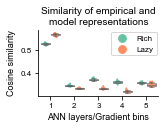

In [126]:
n_hierarchy_bins = 5
bin_stepsize = 72
sorted_hierarchy = sorted(range(len(rsm_gradients[:,0])), key=lambda k: rsm_gradients[:,0][k])

df_annbrainsimilarity = {}
df_annbrainsimilarity['Layer'] = []
df_annbrainsimilarity['Weight initialization'] = []
df_annbrainsimilarity['Representational similarity'] = []
df_annbrainsimilarity['Simulation'] = []

binstart = 0
for bins in range(n_hierarchy_bins):
    bin_ind = sorted_hierarchy[binstart:binstart+bin_stepsize]
    for sim in range(nsimulations):
        rich_ind = np.where(np.asarray(weight_init_range)<1.0)[0]
        lazy_ind = np.where(np.asarray(weight_init_range)>1.0)[0]
        df_annbrainsimilarity['Layer'].append(bins)
        df_annbrainsimilarity['Simulation'].append(sim)
        df_annbrainsimilarity['Weight initialization'].append('Rich')
        binned_avg_rich = np.mean(ann_brain_rsm_match[bin_ind],axis=0)
        df_annbrainsimilarity['Representational similarity'].append(np.mean(binned_avg_rich[bins+1,sim,rich_ind],axis=0))
        #
        df_annbrainsimilarity['Layer'].append(bins)
        df_annbrainsimilarity['Simulation'].append(sim)
        df_annbrainsimilarity['Weight initialization'].append('Lazy')
        binned_avg_lazy = np.mean(ann_brain_rsm_match[bin_ind],axis=0)
        df_annbrainsimilarity['Representational similarity'].append(np.mean(binned_avg_lazy[bins+1,sim,lazy_ind],axis=0))   
        
    binstart += bin_stepsize
df_annbrainsimilarity = pd.DataFrame(df_annbrainsimilarity)

plt.figure(figsize=(2.4,1.9))
ax = sns.boxplot(x="Layer",y="Representational similarity",hue="Weight initialization",data=df_annbrainsimilarity,palette='Set2',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
sns.stripplot(x="Layer",y="Representational similarity",hue="Weight initialization",data=df_annbrainsimilarity,dodge=True,palette='Set2',size=2,zorder=0)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0.2, prop={'size': 8})
plt.xlabel('ANN layers/Gradient bins',fontsize=9)
plt.ylabel('Cosine similarity', fontsize=9)
plt.xticks(np.arange(nlayers),np.arange(1,nlayers+1),fontsize=8)
plt.yticks(fontsize=8)
plt.title('Similarity of empirical and\nmodel representations', fontsize=10)
sns.despine()
plt.tight_layout()
# plt.savefig(figuredir + 'RichVsLazyLearningBrainANNComparison.png',dpi=300)


Rich cosine: 0.39381526593529226
Lazy cosine: 0.3825136067165013
Average cosine difference: 0.011301659218790923
	 t = 3.869931457220992 | p = 0.00019519027939902297


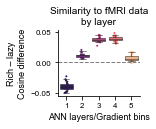

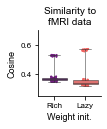

In [127]:

df_similaritydiff = {}
df_similaritydiff['Layer'] = []
df_similaritydiff['Representational similarity'] = []
df_similaritydiff['Simulation'] = []

binstart = 0
for bins in range(n_hierarchy_bins):
    bin_ind = sorted_hierarchy[binstart:binstart+bin_stepsize]
    for sim in range(nsimulations):
        rich_ind = np.where(np.asarray(weight_init_range)<1.0)[0]
        lazy_ind = np.where(np.asarray(weight_init_range)>1.0)[0]
        df_similaritydiff['Layer'].append(bins)
        df_similaritydiff['Simulation'].append(sim)
        binned_avg = np.mean(ann_brain_rsm_match[bin_ind],axis=0)
        diff = np.mean(binned_avg[bins+1,sim,rich_ind],axis=0) - np.mean(binned_avg[bins+1,sim,lazy_ind],axis=0)
        df_similaritydiff['Representational similarity'].append(diff)
        
    binstart += bin_stepsize
df_similaritydiff = pd.DataFrame(df_similaritydiff)

plt.figure(figsize=(2.2,1.9))
ax = sns.boxplot(x="Layer",y="Representational similarity",data=df_similaritydiff,palette='magma',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
sns.stripplot(x="Layer",y="Representational similarity",data=df_similaritydiff,dodge=True,palette='magma',size=2,zorder=0)
plt.plot(np.arange(-0.5,5.5),np.repeat(0,6),linestyle='--',color='gray',linewidth=1)
plt.xlabel('ANN layers/Gradient bins',fontsize=9)
plt.ylabel('Rich – lazy\nCosine difference', fontsize=9)
plt.xticks(np.arange(nlayers),np.arange(1,nlayers+1),fontsize=8)
plt.yticks(fontsize=8)
plt.title('Similarity to fMRI data\nby layer', fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RichVsLazyLearningBrainANNComparison_Difference.pdf')

plt.figure(figsize=(1.6,1.9))
ax = sns.boxplot(x="Weight initialization",y="Representational similarity",data=df_annbrainsimilarity,palette='magma',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
sns.stripplot(x="Weight initialization",y="Representational similarity",data=df_annbrainsimilarity,dodge=True,palette='magma',size=2,zorder=0)
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Cosine', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0.25,0.7])
plt.title('Similarity to\nfMRI data', fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RichVsLazyLearning2Comparison.pdf')

### Run t-test
tmpdf_rich = df_annbrainsimilarity.loc[df_annbrainsimilarity["Weight initialization"]=='Rich']
tmpdf_lazy = df_annbrainsimilarity.loc[df_annbrainsimilarity["Weight initialization"]=='Lazy']
t, p = stats.ttest_rel(tmpdf_rich['Representational similarity'].values,tmpdf_lazy['Representational similarity'].values)
print('Rich cosine:', np.mean(tmpdf_rich['Representational similarity'].values))
print('Lazy cosine:', np.mean(tmpdf_lazy['Representational similarity'].values))
print('Average cosine difference:', np.mean(tmpdf_rich['Representational similarity'].values - tmpdf_lazy['Representational similarity'].values))
print('\t t =', t, '| p =', p)

#### Statistical testing of rich v lazy learning at each layer

In [128]:
ts, ps = [], []
for layer in np.unique(df_annbrainsimilarity.Layer.values):
    tmpdf = df_annbrainsimilarity.loc[df_annbrainsimilarity.Layer==layer]
    tmpdf_rich = tmpdf.loc[tmpdf['Weight initialization']=='Rich']
    tmpdf_lazy = tmpdf.loc[tmpdf['Weight initialization']=='Lazy']
    t, p = stats.ttest_rel(tmpdf_rich['Representational similarity'].values,tmpdf_lazy['Representational similarity'].values)
    ts.append(t)
    ps.append(p)

h0, qs = mc.fdrcorrection0(ps)

for layer in np.unique(df_annbrainsimilarity.Layer.values):
    print('Layer', layer+1, 't =', ts[layer], '| q =', qs[layer])

Layer 1 t = -23.520359110618102 | q = 2.7335517824159087e-15
Layer 2 t = 14.206717633787141 | q = 1.782222992441377e-11
Layer 3 t = 37.25013373702237 | q = 7.908263010065406e-19
Layer 4 t = 37.627288737678136 | q = 7.908263010065406e-19
Layer 5 t = 6.019009928191199 | q = 8.624303208569679e-06


# Number of epochs vs. weight init

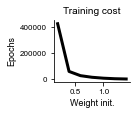

In [155]:
df_nepochs = {}
df_nepochs['Epochs'] = []
df_nepochs['Weight init.'] = []
df_nepochs['Simulation'] = []

w = 0
for weightinit in weight_init_range:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + lr + relu + normalize        
        h5f = h5py.File(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5','r')
        tmprsm = h5f['data'][:].copy()
        nepochs = h5f['nepochs'][()]

        df_nepochs['Simulation'].append(sim)
        df_nepochs['Weight init.'].append(weightinit)
        df_nepochs['Epochs'].append(nepochs)
    w += 1
        

df_nepochs = pd.DataFrame(df_nepochs)


plt.figure(figsize=(2.,1.7))
ax = sns.lineplot(x="Weight init.", y="Epochs", data=df_nepochs,linewidth=3,color='k')
ax.set_ylabel('Epochs', fontsize=9);
ax.set_xlabel('Weight init.', fontsize=9)
ax.set_title('Training cost', fontsize=10)
ax.tick_params(labelsize=8)
sns.despine()
plt.tight_layout()
# plt.savefig(figuredir + 'TrainingCost.png',dpi=300,transparent=True)

# Compute ANN RA matrix

In [133]:
model_rsms = []
df_dim_group = pd.DataFrame()
for weightinit in weight_init_range:
    model_rsms.append([])
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + lr + relu + normalize
        # Load dimensionality
        df_dim = pd.read_csv(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv')
        tmpdf = df_dim.groupby('Layer',as_index=False).mean()
        tmpdf.insert(loc=0,column='WeightInit', value=np.repeat(weightinit,nlayers+2))
        tmpdf.insert(loc=0,column='Simulation', value=np.repeat(sim,nlayers+2))

        df_dim_group = df_dim_group.append(tmpdf)
        
        ####
        # Load analysis
        h5f = h5py.File(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5','r')
        tmprsm = h5f['data'][:].copy()
        tmprsm = np.mean(tmprsm,axis=0) # average across subjects
        model_rsms[-1].append(tmprsm)

model_rsms = np.asarray(model_rsms)    
        
    


# Calculate representational alignment across layers

In [134]:
alllayers = model_rsms.shape[2]
triu_ind = np.triu_indices(45,k=0)
ra_mat = np.zeros((len(weight_init_range),nsimulations,alllayers,alllayers))
for weightinit in range(len(weight_init_range)):
    for sim in range(nsimulations):
        for layer1 in range(alllayers):
            for layer2 in range(alllayers):
                if layer2>layer1:
                    cosinesim = np.dot(model_rsms[weightinit,sim,layer1][triu_ind],model_rsms[weightinit,sim,layer2][triu_ind])/(np.linalg.norm(model_rsms[weightinit,sim,layer1][triu_ind]*np.linalg.norm(model_rsms[weightinit,sim,layer2][triu_ind])))
                    ra_mat[weightinit,sim,layer1,layer2] = cosinesim
        
        ra_mat[weightinit,sim] = ra_mat[weightinit,sim] + ra_mat[weightinit,sim].T
        np.fill_diagonal(ra_mat[weightinit,sim],1)
ra_mat_avg = np.mean(ra_mat,axis=1)

/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


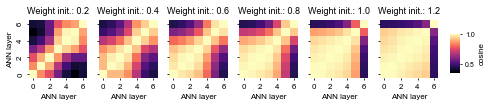

In [153]:
weights_to_plot = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
vmin = np.min(ra_mat)
vmax = np.max(ra_mat)

fig, axn = plt.subplots(1, 6, sharex=True, sharey=True,figsize=(7,1.35))
cbar_ax = fig.add_axes([.9, .3, .02, .4])
i = 0
for weight in weights_to_plot:
    weight_ind = np.where(np.asarray(weight_init_range)==weight)[0][0]
    ax = axn.flat[i]
    tmpax = sns.heatmap(ra_mat_avg[weight_ind],square=True, ax=ax, cbar=i == 0, vmin=vmin, vmax=vmax, cmap='magma',cbar_ax=None if i else cbar_ax,cbar_kws={'fraction':0.04,'label':'cosine'})
    ax.set_title('Weight init.: ' + str(weight),fontsize=9)
    tmpax.invert_yaxis()
    ax.tick_params(size=2,labelsize=8)
    if i in [0,1,2, 3, 4, 5, 6]: 
        ax.set_xlabel('ANN layer',size=8)
    if i in [0]:
        ax.set_ylabel('ANN layer', fontsize=8)
        ax.set_yticks([])
    
    i += 1
cax = plt.gcf().axes[-1]
cax.yaxis.label.set_size(8)
cax.tick_params(size=2,labelsize=7)
fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(figuredir + 'ANN_RAMatrix.pdf')



# Plot mean RA cosine across layers

Rich versus lazy, cosine difference: -0.05679869173973007
Rich vs. lazy, t = -123.35784083367133 | p = 4.655209124091692e-29


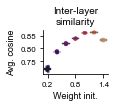

In [143]:
mean_cosine = {}
mean_cosine['Simulation'] = []
mean_cosine['Cosine'] = []
mean_cosine['Weight init.'] = []
mean_cosine['Training'] = []
i = 0
for weight in weight_init_range:
    ind = np.where(np.asarray(weight_init_range)==weight)[0][0]
    for sim in range(nsimulations):
        mean_cosine['Simulation'].append(sim)
        mean_cosine['Cosine'].append(np.mean(ra_mat[ind,sim]))
        mean_cosine['Weight init.'].append(weight)
        if weight < 1.0: 
            mean_cosine['Training'].append("Rich")
        elif weight > 1.0: 
            mean_cosine['Training'].append("Lazy")
        else: 
            mean_cosine['Training'].append("1.0")
    i += 1
    
plt.figure(figsize=(1.7 ,1.6))
ax = sns.boxplot(x='Weight init.', y='Cosine', data=mean_cosine, palette='magma', sym='',whis=[2.5,97.5],linewidth=0.25)
sns.stripplot(x='Weight init.', y='Cosine', data=mean_cosine, palette='magma',dodge=True,size=3,zorder=0,alpha=0.6)
plt.xticks(np.arange(0,len(weight_init_range),3),weight_init_range[::3],rotation=0,fontsize=8)
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Avg. cosine', fontsize=9);
plt.yticks(fontsize=8)
plt.title('Inter-layer\nsimilarity',fontsize=10)
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'LayerCosine_Vs_WeightInitialization.pdf')

### Run rich v. lazy statistics
mean_cosine = pd.DataFrame(mean_cosine)
tmprich = mean_cosine.loc[mean_cosine.Training=='Rich']
tmprich = tmprich.groupby(by="Simulation").mean()
tmplazy = mean_cosine.loc[mean_cosine.Training=='Lazy']
tmplazy = tmplazy.groupby(by="Simulation").mean()
t, p = stats.ttest_rel(tmprich.Cosine.values,tmplazy.Cosine.values)
print('Rich versus lazy, cosine difference:', np.mean(tmprich.Cosine.values)-np.mean(tmplazy.Cosine.values))
print("Rich vs. lazy, t =", t, '| p =', p)

# Plot scree plots for each matrix

Rich versus lazy, Variance explained difference: -0.044035651849910096
Rich vs. lazy, t = -29.646583262501935 | p = 2.2565847373167916e-17


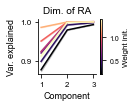

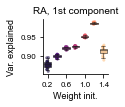

In [156]:
import sklearn

n_components = 3
df_pca = {}
df_pca['Weight init.'] = []
df_pca['Variance explained'] = []
df_pca['Component'] = []
df_pca['Simulation'] = []
df_pca['Training'] = []

principal_gradient_loadings = np.zeros((nlayers+2,len(weight_init_range),nsimulations))

for sim in range(nsimulations):
    i = 0
    for weight in weight_init_range:
        weight_ind = np.where(np.asarray(weight_init_range)==round(weight,1))[0][0]
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(ra_mat[weight_ind,sim,:,:])
        var_explained = 0
        for comp in range(n_components):
            if comp==0: principal_gradient_loadings[:,i,sim] = pca.components_[0]
            var_explained += pca.explained_variance_ratio_[comp]
            df_pca['Weight init.'].append(round(weight,1))
            df_pca['Variance explained'].append(var_explained)
            df_pca['Component'].append(comp)
            df_pca['Simulation'].append(sim)
            if weight < 1.0: 
                df_pca['Training'].append("Rich")
            elif weight > 1.0: 
                df_pca['Training'].append("Lazy")
            else: 
                df_pca['Training'].append("1.0")
        i += 1
    
df_pca = pd.DataFrame(df_pca)

fig = plt.figure(figsize=(2.0,1.6))
ax = sns.lineplot(x="Component",y="Variance explained",hue="Weight init.",data=df_pca,palette='magma',legend=False)
plt.xticks(np.arange(0,n_components),np.arange(1,n_components+1),fontsize=8)
plt.yticks(fontsize=8)
plt.title('Dim. of RA',fontsize=10);
plt.xlabel('Component',fontsize=9)
plt.ylabel('Var. explained',fontsize=9)

norm = plt.Normalize(df_pca['Weight init.'].min(), df_pca['Weight init.'].max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm)
cax.ax.tick_params(labelsize=7)
cax.ax.set_ylabel('Weight init.', fontsize=8);
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'ANNLayer_Screeplot.pdf')


tmpdf = df_pca.loc[df_pca.Component==0]

fig = plt.figure(figsize=(1.7,1.6))
# ax = plt.subplot(1,1,1,)
ax = sns.boxplot(x="Weight init.",y="Variance explained",data=tmpdf,palette='magma',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
ax = sns.stripplot(x="Weight init.",y="Variance explained",data=tmpdf,palette='magma',size=3,zorder=0,alpha=0.6)
plt.xticks(np.arange(0,len(weight_init_range),2),weight_init_range[::2],fontsize=8)
plt.title('RA, 1st component',fontsize=10);
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Var. explained',fontsize=9)
ax.tick_params(axis='x',labelsize=8,rotation=0)
ax.tick_params(axis='y',labelsize=8,rotation=0)
sns.despine()
plt.tight_layout()
# plt.savefig(figuredir + 'ANNLayer_1stCompVarExplained.pdf')

### Run rich v. lazy statistics
tmprich = tmpdf.loc[tmpdf.Training=='Rich']
tmprich = tmprich.groupby(by="Simulation").mean()
tmplazy = tmpdf.loc[tmpdf.Training=='Lazy']
tmplazy = tmplazy.groupby(by="Simulation").mean()
t, p = stats.ttest_rel(tmprich['Variance explained'].values,tmplazy['Variance explained'].values)
print('Rich versus lazy, Variance explained difference:', np.mean(tmprich['Variance explained'].values)-np.mean(tmplazy['Variance explained'].values))
print("Rich vs. lazy, t =", t, '| p =', p)

# Assess weight statistics of ANNs for different initialization schemes

In [150]:
nsubjs=24
nlayers=5
norm_mat = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights
bias_mat = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights

norm_mat_init = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights
bias_mat_init = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights

df_ann = {}
df_ann['Simulation'] = []
df_ann['WeightInitialization'] = []
df_ann['Training'] = []
df_ann['WeightNorm'] = []
df_ann['WeightMean'] = []
df_ann['WeightSD'] = []
df_ann['WeightKurtosis'] = []
df_ann['BiasNorm'] = []
df_ann['BiasMean'] = []
df_ann['BiasSD'] = []
df_ann['BiasKurtosis'] = []
df_ann['Regime'] = []

df_dist = {}
df_dist['WeightNorm'] = []
df_dist['WeightMean'] = []
df_dist['WeightInitialization'] = []

w = 0
for weightinit in weight_init_range:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + lr +  relu + normalize        
        h5f = h5py.File(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5','r')
        tmprsm = h5f['data'][:].copy()
        edge_mean, edge_norm, edge_sd, edge_kurtosis = h5f['edge_mean'][:].copy(), h5f['edge_norm'][:].copy(), h5f['edge_sd'][:].copy(), h5f['edge_kurtosis'][:].copy()
        bias_mean, bias_norm, bias_sd, bias_kurtosis = h5f['bias_mean'][:].copy(), h5f['bias_norm'][:].copy(), h5f['bias_sd'][:].copy(), h5f['bias_kurtosis'][:].copy()
        #
        edge_mean_init, edge_norm_init, edge_sd_init, edge_kurtosis_init = h5f['edge_mean_init'][:].copy(), h5f['edge_norm_init'][:].copy(), h5f['edge_sd_init'][:].copy(), h5f['edge_kurtosis_init'][:].copy()
        bias_mean_init, bias_norm_init, bias_sd_init, bias_kurtosis_init = h5f['bias_mean_init'][:].copy(), h5f['bias_norm_init'][:].copy(), h5f['bias_sd_init'][:].copy(), h5f['bias_kurtosis_init'][:].copy()
        h5f.close()
        
        norm_mat[:,sim-1,w] = np.mean(np.linalg.norm(edge_norm,axis=2),axis=1)
        bias_mat[:,sim-1,w] = np.mean(bias_norm,axis=1)
        
        norm_mat_init[:,sim-1,w] = np.mean(np.linalg.norm(edge_norm,axis=2),axis=1)
        bias_mat_init[:,sim-1,w] = np.mean(bias_norm_init,axis=1)
        
        df_dist['WeightNorm'].extend(np.mean(edge_norm,axis=1).reshape(-1))
        df_dist['WeightMean'].extend(np.mean(edge_mean,axis=1).reshape(-1))
        df_dist['WeightInitialization'].extend(np.repeat(weightinit,len(np.mean(edge_mean,axis=1).reshape(-1))))
        
        df_ann['Simulation'].append(sim)
        df_ann['WeightInitialization'].append(weightinit)
        df_ann['Training'].append('Trained')
        df_ann['WeightNorm'].append(np.mean(np.linalg.norm(edge_norm,axis=2)))
        df_ann['WeightMean'].append(np.mean(np.mean(edge_mean,axis=2)))
        df_ann['WeightSD'].append(np.mean(np.mean(edge_sd,axis=2)))
        df_ann['WeightKurtosis'].append(np.mean(np.mean(edge_kurtosis,axis=2)))
        df_ann['BiasNorm'].append(np.mean(bias_norm))
        df_ann['BiasMean'].append(np.mean(bias_mean))
        df_ann['BiasSD'].append(np.mean(bias_sd))
        df_ann['BiasKurtosis'].append(np.mean(bias_kurtosis))
        if weightinit<1.0:
            df_ann['Regime'].append('Rich')
        elif weightinit>1.0:
            df_ann['Regime'].append('Lazy')
        else:
            df_ann['Regime'].append('1.0')
            
        df_ann['Simulation'].append(sim)
        df_ann['WeightInitialization'].append(weightinit)
        df_ann['Training'].append('Untrained')
        df_ann['WeightNorm'].append(np.mean(np.linalg.norm(edge_norm_init,axis=2)))
        df_ann['WeightMean'].append(np.mean(np.mean(edge_mean_init,axis=2)))
        df_ann['WeightSD'].append(np.mean(np.mean(edge_sd_init,axis=2)))
        df_ann['WeightKurtosis'].append(np.mean(np.mean(edge_kurtosis_init,axis=2)))
        df_ann['BiasNorm'].append(np.mean(bias_norm_init))
        df_ann['BiasMean'].append(np.mean(bias_mean_init))
        df_ann['BiasSD'].append(np.mean(bias_sd_init))
        df_ann['BiasKurtosis'].append(np.mean(bias_kurtosis_init))
        if weightinit<1.0:
            df_ann['Regime'].append('Rich')
        elif weightinit>1.0:
            df_ann['Regime'].append('Lazy')
        else:
            df_ann['Regime'].append('1.0')

    w += 1
        
df_ann = pd.DataFrame(df_ann)
df_trained = df_ann.loc[df_ann.Training=='Trained']
df_untrained = df_ann.loc[df_ann.Training=='Untrained']

df_dist = pd.DataFrame(df_dist)

# Plot singular values of weight matrices

In [165]:
n_svalues = 50
df_svd = {}
df_svd['init'] = []
df_svd['sim'] = []
df_svd['singular'] = []
df_svd['singular range'] = []

w = 0
for weightinit in weight_init_range:
# for weightinit in [0.2, ]:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + lr+ relu + normalize    
        try:
            h5f = h5py.File(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied +'.h5','r')
            weights = h5f['weights'][:].copy()
            h5f.close()

            SVD = sklearn.decomposition.TruncatedSVD(n_svalues)
            SVD.fit(weights)
#             svalues = SVD.singular_values_
            svalues = SVD.explained_variance_ratio_
            df_svd['init'].extend(np.repeat(weightinit,n_svalues))
            df_svd['sim'].extend(np.repeat(sim,n_svalues))
            df_svd['singular'].extend(svalues)
            df_svd['singular range'].extend(np.arange(n_svalues))
        except:
            print(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5')

df_svd = pd.DataFrame(df_svd)

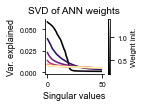

In [166]:
fig = plt.figure(figsize=(2.0,1.6))
ax = sns.lineplot(x='singular range', y ='singular', hue='init', data=df_svd,legend=False,palette='magma')
ax.set_ylabel('Var. explained', fontsize=9)
ax.set_xlabel('Singular values', fontsize=9)
ax.tick_params(labelsize=7)
ax.set_title('SVD of ANN weights',fontsize=10)

norm = plt.Normalize(df_svd['init'].min(), df_svd['init'].max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm)
cax.ax.tick_params(labelsize=7)
cax.ax.set_ylabel('Weight init.', fontsize=8);
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'ANN_WeightSVD.pdf')

In [168]:
df_dim = {}
df_dim['init'] = []
df_dim['sim'] = []
df_dim['dimensionality'] = []
df_dim['training'] = []

w = 0
for weightinit in weight_init_range:
# for weightinit in [0.2, ]:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + lr + relu + normalize    
        try:
            h5f = h5py.File(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5','r')
            weights = h5f['weights'][:].copy()
            h5f.close()

    #             SVD = sklearn.decomposition.TruncatedSVD(n_values)
    #             SVD.fit(weights)s
            mat = np.cov(weights)
            dim = dimensionality.getDimensionality(mat)
#             svalues = SVD.singular_values_
            svalues = SVD.explained_variance_ratio_
            df_dim['init'].append(weightinit)
            df_dim['sim'].append(sim)
            df_dim['dimensionality'].append(dim)
            if weightinit<1.0:
                df_dim['training'].append('Rich')
            elif weightinit>1.0:
                df_dim['training'].append('Lazy')
            else: 
                df_dim['training'].append(1.0)
        except:
            print(basedir + 'derivatives/results/analysis5_sgd_revision/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.h5')

df_dim = pd.DataFrame(df_dim)

Rich Dimensionality: 123.36575272599187
Lazy Dimensionality: 247.745957410763
Rich versus lazy, Dimensionality: -124.38020468477113
Rich vs. lazy, t = -1059.7725587176049 | p = 8.431473858463457e-47


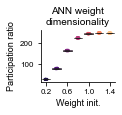

In [174]:
fig, ax1 = plt.subplots(figsize=(1.8,1.7))
ax = sns.boxplot(x='init',y='dimensionality',data=df_dim,palette='magma',sym='',whis=[2.5,97.5],linewidth=0.5)
ax = sns.stripplot(x='init',y='dimensionality',data=df_dim,palette='magma',size=3,zorder=0,alpha=0.6)
plt.xticks(np.arange(0,len(weight_init_range),2),weight_init_range[::2],fontsize=8)
# plt.yticks(fontsize=8)
plt.title('ANN weight\ndimensionality',fontsize=10);
# plt.xlabel('Component',fontsize=9)
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Participation ratio',fontsize=9)
ax.tick_params(axis='x',labelsize=8,rotation=0)
ax.tick_params(axis='y',labelsize=8,rotation=0)
# plt.ylim([0,130])
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'ANNWeightDimensionality.pdf')

### Run rich v. lazy statistics
tmprich = df_dim.loc[df_dim.training=='Rich']
tmprich = tmprich.groupby(by="sim").mean()
tmplazy = df_dim.loc[df_dim.training=='Lazy']
tmplazy = tmplazy.groupby(by="sim").mean()
t, p = stats.ttest_rel(tmprich['dimensionality'].values,tmplazy['dimensionality'].values)
print('Rich Dimensionality:', np.mean(tmprich['dimensionality'].values))
print('Lazy Dimensionality:', np.mean(tmplazy['dimensionality'].values))
print('Rich versus lazy, Dimensionality:', np.mean(tmprich['dimensionality'].values)-np.mean(tmplazy['dimensionality'].values))
print("Rich vs. lazy, t =", t, '| p =', p)

___